---
GPU-accelerated Bio-Heat Transfer Equation (BHTE)
---

## Description
The code in this notebook implements a Finite-Difference Time-Difference (FDTD) of the partial differential equation (PDE) of the BioHeat Thermal Equation (BHTE) using one of the following GPU backends: CUDA, OpenCL, or Metal

The BHTE is given by
$$
\rho_t c_t \frac{\partial \theta_m}{\partial t} = \nabla \cdot \left(  k_t \nabla \theta_m \right ) - \omega_b c_b \left(  \theta_m - \theta_a \right ) + Q_m
$$

 where $\theta_m$ is the instantaneous temperature at point $m$. $\rho_t$, $c_t$ and $k_t$ are, respectively, the density, specific heat capacity and thermal conductivity of the tissue. $\omega_b$ and $c_b$ are, respectively, the perfusion rate and heat capacity of blood. $\theta_a$ is the body temperature. The term $Q_m$ is the absorbed energy rate due to the absorption of ultrasound by the tissue.

The equation is solved with forward-step solution  $\theta_m(T+t_0)$. This means the GPU kernel is called thousands of times as the thermal map $\theta_m$ is updated in small temporal $\delta t$ steps.



## Imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from BabelViscoFDTD.tools.RayleighAndBHTE import BHTE,InitCUDA, InitOpenCL, InitMetal, InitMLX
from skimage.metrics import mean_squared_error, normalized_root_mse

## Parameters

In [2]:
# Device Specific
gpu_device = 'M1'
# gpu_backend = 'CUDA'
# gpu_backend = 'OpenCL'
gpu_backend = 'Metal'
# gpu_backend = 'MLX'

# Simulation
BaseIsppa = 5               # W/cm2
BaselineTemperature = 37.0  
dt = 0.01                   # Time step
DutyCycle = 0.1
DurationUS = 120            # Time that ultrasound is on
DurationOff = 120           # Time that ultrasound is off
Repetitions = 1             # Number of cycles of DurationUS + DurationOff
Frequency = 400e3           # Ultrasound frequency
PPW = 6                     # Points Per Wavelength

## Support Functions

In [3]:
def AnalyzeLosses(pAmp,MaterialMap,LocIJK,Input,MaterialList,BrainID,pAmpWater,Isppa,SaveDict,xf,yf,zf):
    pAmpBrain=pAmp.copy()
    if 'MaterialMapCT' in Input:
        pAmpBrain[MaterialMap!=2]=0.0
    else:
        pAmpBrain[MaterialMap<4]=0.0

    cz=LocIJK[2]
    
    PlanAtMaximum=pAmpBrain[:,:,cz]
    AcousticEnergy=(PlanAtMaximum**2/2/MaterialList['Density'][BrainID]/ MaterialList['SoS'][BrainID]*((xf[1]-xf[0])**2)).sum()
    print('Acoustic Energy at maximum plane',AcousticEnergy)
    
    
    MateriaMapTissue=np.ascontiguousarray(np.flip(Input['MaterialMap'],axis=2))
    xfr=Input['x_vec']
    yfr=Input['y_vec']
    zfr=Input['z_vec']
    
    
    PlanAtMaximumWater=pAmpWater[:,:,2] 
    AcousticEnergyWater=(PlanAtMaximumWater**2/2/MaterialList['Density'][0]/ MaterialList['SoS'][0]*((xf[1]-xf[0])**2)).sum()
    print('Water Acoustic Energy entering',AcousticEnergyWater)
    if 'MaterialMapCT' in Input:
        pAmpWater[MaterialMap!=2]=0.0
    else:
        pAmpWater[MaterialMap!=4]=0.0
    cxw,cyw,czw=np.where(pAmpWater==pAmpWater.max())
    cxw=cxw[0]
    cyw=cyw[0]
    czw=czw[0]
    print('Location Max Pessure Water',cxw,cyw,czw,'\n',
            xf[cxw],yf[cyw],zf[czw],pAmpWater.max()/1e6)
    
    pAmpTissue=np.ascontiguousarray(np.flip(Input['p_amp'],axis=2))
    if 'MaterialMapCT' in Input:
        pAmpTissue[MaterialMap!=2]=0.0
    else:
        pAmpTissue[MaterialMap!=4]=0.0

    cxr,cyr,czr=np.where(pAmpTissue==pAmpTissue.max())
    cxr=cxr[0]
    cyr=cyr[0]
    czr=czr[0]
    print('Location Max Pressure Tissue',cxr,cyr,czr,'\n',
            xfr[cxr],yfr[cyr],zfr[czr],pAmpTissue.max()/1e6)
    

    PlanAtMaximumWaterMaxLoc=pAmpWater[:,:,czw]
    AcousticEnergyWaterMaxLoc=(PlanAtMaximumWaterMaxLoc**2/2/MaterialList['Density'][0]/ MaterialList['SoS'][0]*((xf[1]-xf[0])**2)).sum()
    print('Water Acoustic Energy at maximum plane water max loc',AcousticEnergyWaterMaxLoc) #must be very close to AcousticEnergyWater
    
    PlanAtMaximumWaterMaxLoc=pAmpWater[:,:,czr]
    AcousticEnergyWaterMaxLoc=(PlanAtMaximumWaterMaxLoc**2/2/MaterialList['Density'][0]/ MaterialList['SoS'][0]*((xf[1]-xf[0])**2)).sum()
    print('Water Acoustic Energy at maximum plane tissue max loc',AcousticEnergyWaterMaxLoc) #must be very close to AcousticEnergyWater
    
    PlanAtMaximumTissue=pAmpTissue[:,:,czr] 
    AcousticEnergyTissue=(PlanAtMaximumTissue**2/2/MaterialList['Density'][BrainID]/ MaterialList['SoS'][BrainID]*((xf[1]-xf[0])**2)).sum()
    print('Tissue Acoustic Energy at maximum plane tissue',AcousticEnergyTissue)
    
    RatioLosses=AcousticEnergyTissue/AcousticEnergyWaterMaxLoc
    print('Total losses ratio and in dB',RatioLosses,np.log10(RatioLosses)*10)
        
    PressureAdjust=np.sqrt(Isppa*1e4*2.0*SaveDict['MaterialList']['SoS'][BrainID]*SaveDict['MaterialList']['Density'][BrainID])
    PressureRatio=PressureAdjust/pAmpTissue.max()
    return PressureRatio,RatioLosses

def getBHTECoefficient( kappa,rho,c_t,h,t_int,dt=0.1):
    """ calculates the Bioheat Transfer Equation coefficient required (time step/density*conductivity*voxelsize"""
    # get the bioheat coefficients for a tissue type -- independent of surrounding tissue types
    # dt = t_int/nt
    # h - voxel resolution - default 1e-3

    bhc_coeff = kappa * dt / (rho * c_t * h**2)
    if bhc_coeff >= (1 / 6):
        best_nt = np.ceil(6 * kappa * t_int) / (rho * c_t *h**2)
        print("The conditions %f,%f,%f does not meet the C-F-L condition and may not be stable. Use nt of %f or greater." %\
            (dt,t_int,bhc_coeff,best_nt))
    return bhc_coeff

def getPerfusionCoefficient( w_b,c_t,blood_rho,blood_ct,dt=0.1):
    """Calculates the perfusion coefficient based on the simulation parameters and time step """
    # get the perfusion coeff for a speicfic tissue type and time period  -- independent of surrounding tissue types
    # wb is in ml/min/kg, needs to be converted to m3/s/kg (1min/60 * 1e-6 m3/ml)

    coeff = w_b/60*1.0e-6* blood_rho * blood_ct * dt / c_t  

    return coeff

def getQCoeff(rho,SoS,alpha,c_t,Absorption,h,dt):
    coeff=dt/(2*rho**2*SoS*h*c_t)*Absorption*(1-np.exp(-2*h*alpha))
    return coeff

def factors_gpu(x):
    res=[]
    for i in range(2, x + 1):
        if x % i == 0:
            res.append(i)
    res=np.array(res)
    return res

def FitSpeedCorticalShear(frequency):
    #from Phys Med Biol. 2017 Aug 7; 62(17): 6938–6962. doi: 10.1088/1361-6560/aa7ccc 
    FRef=np.array([270e3,836e3])
    Cs270=np.array([1577.0,1498.0,1313.0]).mean()
    Cs836=np.array([1758.0,1674.0,1545.0]).mean()
    CsRef=np.array([Cs270,Cs836])
    p=np.polyfit(FRef, CsRef, 1)
    return(np.round(np.poly1d(p)(frequency)))

def FitSpeedTrabecularShear(frequency):
    #from Phys Med Biol. 2017 Aug 7; 62(17): 6938–6962. doi: 10.1088/1361-6560/aa7ccc 
    FRef=np.array([270e3,836e3])
    Cs270=np.array([1227.0,1365.0,1200.0]).mean()
    Cs836=np.array([1574.0,1252.0,1327.0]).mean()
    CsRef=np.array([Cs270,Cs836])
    p=np.polyfit(FRef, CsRef, 1)
    return(np.round(np.poly1d(p)(frequency)))

def FitAttBoneShear(frequency,reductionFactor=1.0):
    #from Phys Med Biol. 2017 Aug 7; 62(17): 6938–6962. doi: 10.1088/1361-6560/aa7ccc 
    PichardoData=(57.0/.27 +373/0.836)/2
    return np.round(PichardoData*(frequency/1e6)*reductionFactor) 

def FitSpeedCorticalLong(frequency):
    #from Phys Med Biol. 2011 Jan 7; 56(1): 219–250. doi :10.1088/0031-9155/56/1/014 
    FRef=np.array([270e3,836e3])
    ClRef=np.array([2448.0,2516])
    p=np.polyfit(FRef, ClRef, 1)
    return(np.round(np.poly1d(p)(frequency)))

def FitSpeedTrabecularLong(frequency):
    #from Phys Med Biol. 2011 Jan 7; 56(1): 219–250. doi :10.1088/0031-9155/56/1/014
    FRef=np.array([270e3,836e3])
    ClRef=np.array([2140.0,2300])
    p=np.polyfit(FRef, ClRef, 1)
    return(np.round(np.poly1d(p)(frequency)))

def FitAttCorticalLong_Goss(frequency,reductionFactor=1):
    #from J. Acoust. Soc. Am., Vol. 64, No. 2,  doi: 10.1121/1.382016
    JasaAtt1MHz=(2.15+1.67)/2*100*reductionFactor
    return np.round(JasaAtt1MHz*(frequency/1e6)) 

def FitAttTrabecularLong_Goss(frequency,reductionFactor=1):
    #from J. Acoust. Soc. Am., Vol. 64, No. 2,  doi: 10.1121/1.382016
    JasaAtt1MHz=1.5*100*reductionFactor
    return np.round(JasaAtt1MHz*(frequency/1e6)) 

def FitAttCorticalLong_Multiple(frequency,bcoeff=1,reductionFactor=0.8):
    # fitting from data obtained from
    #J. Acoust. Soc. Am., Vol. 64, No. 2,  doi: 10.1121/1.382016
    # Phys Med Biol. 2011 Jan 7; 56(1): 219–250. doi :10.1088/0031-9155/56/1/014
    # IEEE transactions on ultrasonics, ferroelectrics, and frequency control 68, no. 5 (2020): 1532-1545. doi: 10.1109/TUFFC.2020.3039743
    
    return np.round(203.25090263*((frequency/1e6)**bcoeff)*reductionFactor)

def FitAttTrabecularLong_Multiple(frequency,bcoeff=1,reductionFactor=0.8):
    #reduction factor 
    # fitting from data obtained from
    #J. Acoust. Soc. Am., Vol. 64, No. 2,  doi: 10.1121/1.382016
    # Phys Med Biol. 2011 Jan 7; 56(1): 219–250. doi :10.1088/0031-9155/56/1/014
    # IEEE transactions on ultrasonics, ferroelectrics, and frequency control 68, no. 5 (2020): 1532-1545. doi: 10.1109/TUFFC.2020.3039743
    return np.round(202.76362433*((frequency/1e6)**bcoeff)*reductionFactor)

def GetMaterialList(Frequency,BaselineTemperature):
    MatFreq={}
    Material={}
    #Density (kg/m3), LongSoS (m/s), ShearSoS (m/s), Long Att (Np/m), Shear Att (Np/m)
    Material['Water']=     np.array([1000.0, 1500.0, 0.0   ,   0.0,                   0.0] )
    Material['Cortical']=  np.array([1896.5, FitSpeedCorticalLong(Frequency), 
                                                FitSpeedCorticalShear(Frequency),  
                                                FitAttCorticalLong_Multiple(Frequency)  , 
                                                FitAttBoneShear(Frequency)])
    Material['Trabecular']=np.array([1738.0, FitSpeedTrabecularLong(Frequency),
                                                FitSpeedTrabecularShear(Frequency),
                                                FitAttTrabecularLong_Multiple(Frequency) , 
                                                FitAttBoneShear(Frequency)])
    Material['Skin']=      np.array([1116.0, 1537.0, 0.0   ,  2.3*Frequency/500e3 , 0])
    Material['Brain']=     np.array([1041.0, 1562.0, 0.0   ,  3.45*Frequency/500e3 , 0])

    MatFreq[Frequency]=Material

    Input = {}
    Materials = []
    for k in ['Water','Skin','Cortical','Trabecular','Brain']:
        SelM = MatFreq[Frequency][k]
        Materials.append([SelM[0], # Density
                        SelM[1], # Longitudinal SOS
                        SelM[2], # Shear SOS
                        SelM[3], # Long Attenuation
                        SelM[4]]) # Shear Attenuation
    Materials = np.array(Materials)
    MaterialList = {}
    MaterialList['Density'] = Materials[:,0]
    MaterialList['SoS'] = Materials[:,1]
    MaterialList['Attenuation'] = Materials[:,3]

    #Water, Skin, Cortical, Trabecular, Brain

    #https://itis.swiss/virtual-population/tissue-properties/database/heat-capacity/
    MaterialList['SpecificHeat']=[4178,3391,1313,2274,3630] #(J/kg/°C)
    #https://itis.swiss/virtual-population/tissue-properties/database/thermal-conductivity/
    MaterialList['Conductivity']=[0.6,0.37,0.32,0.31,0.51] # (W/m/°C)
    #https://itis.swiss/virtual-population/tissue-properties/database/heat-transfer-rate/
    MaterialList['Perfusion']=np.array([0,106,10,30,559])

    MaterialList['Absorption']=np.array([0,0.85,0.16,0.15,0.85])

    MaterialList['InitTemperature']=[BaselineTemperature,BaselineTemperature,
                                        BaselineTemperature,BaselineTemperature,BaselineTemperature]
    
    return MaterialList

## Initialize GPU Backend

In [4]:
if gpu_backend == 'CUDA':
    InitCUDA(gpu_device)
elif gpu_backend == "OpenCL":
    InitOpenCL(gpu_device)
elif gpu_backend == 'Metal':
    InitMetal(gpu_device)
else:
    InitMLX(gpu_device)

loading /Users/acoreas/opt/anaconda3/envs/bbmac_visco/lib/python3.9/site-packages/BabelViscoFDTD/tools/libBabelMetal.dylib
Metal devices
Apple M1 Max
Is device low power? false.
Is device external? false.
Maximum threads per group: MTLSize(width: 1024, height: 1024, depth: 1024).
loaded Metal <CDLL '/Users/acoreas/opt/anaconda3/envs/bbmac_visco/lib/python3.9/site-packages/BabelViscoFDTD/tools/libBabelMetal.dylib', handle 81e1c800 at 0x11ae1b640>
Maximum buffer length: 36.0 GB.
Selecting device:  Apple M1 Max
metalcompute.Device(Apple M1 Max)


## Simulation Domain Setup

114 114 193


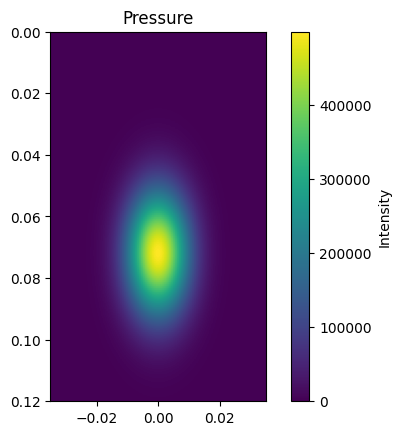

In [5]:
# Domain properties
MediumSOS = 1500 # m/s - water
MediumDensity = 1000 # kg/m3
ShortestWavelength = MediumSOS / Frequency
SpatialStep = ShortestWavelength / PPW

#Limits of domain, in mm
xfmin=-3.5e-2
xfmax=3.5e-2
yfmin=-3.5e-2
yfmax=3.5e-2
zfmin=0.
zfmax=12e-2

# x,y,z points
xfield = np.linspace(xfmin,xfmax,int(np.ceil((xfmax-xfmin)/SpatialStep)+1))
yfield = np.linspace(yfmin,yfmax,int(np.ceil((yfmax-yfmin)/SpatialStep)+1))
zfield = np.linspace(zfmin,zfmax,int(np.ceil((zfmax-zfmin)/SpatialStep)+1))

# Number of points in each axis
nxf=len(xfield) 
nyf=len(yfield)
nzf=len(zfield)
print(nxf,nyf,nzf)

# Grid formation
xp,yp,zp=np.meshgrid(xfield,yfield,zfield,indexing='ij')

# Generate pressure map for grid shaped as an ellipsoid
radius_x, radius_y, radius_z = 0.01, 0.01, 0.02
x_offset, y_offset, z_offset = 0.0*xfmax, 0.0*yfmax, 0.6*zfmax 
ellipsoid = ((xp - x_offset) / radius_x) ** 2 + ((yp - y_offset) / radius_y) ** 2 + ((zp - z_offset) / radius_z) ** 2
pressure = np.exp(-ellipsoid) * 500000  # Use an exponential decay for smoothness

# Middles slice indexes
cx=nxf//2
cy=nyf//2
cz=nzf//2

# Visualize pressure plot
plt.imshow(pressure[:,cy,:].T, extent=(xfmin,xfmax,zfmax,zfmin))
plt.colorbar(label="Intensity")
plt.title("Pressure")
plt.show()


## BHTE Setup

In [6]:
# Create Material Map
# All water
# MaterialMap = np.zeros_like(pressure,dtype=np.uint32)

# All tissues
# MaterialMap = np.zeros_like(pressure,dtype=np.uint32)
# tissue_start = nzf//10
# MaterialMap[:,:,tissue_start:tissue_start+2] = 1
# MaterialMap[:,:,tissue_start+2:tissue_start+5] = 2
# MaterialMap[:,:,tissue_start+5:tissue_start+11] = 3
# MaterialMap[:,:,tissue_start+11:tissue_start+14] = 2
# MaterialMap[:,:,tissue_start+14:] = 4

# All Brain
MaterialMap = 4*np.ones_like(pressure,dtype=np.uint32)

# Determine material properties for specified frequency
MaterialList = GetMaterialList(Frequency,BaselineTemperature)

# Create masks
SelSkin = MaterialMap==1
SelSkull = (MaterialMap>1) & (MaterialMap<4)
SelBrain = MaterialMap==4

# Other BHTE parameters
nFactorMonitoring=int(50e-3/dt) # we just track every 50 ms
TotalDurationSteps=int((DurationUS+.001)/dt)
nStepsOn=int(DurationUS/dt) 
TotalDurationStepsOff=int((DurationOff+.001)/dt)


## Run BHTE

In [7]:
ResTemp,ResDose,MonitorSlice,Qarr = BHTE(pressure,
                                         MaterialMap,
                                         MaterialList,
                                         (xfield[1]-xfield[0]),
                                         TotalDurationSteps,
                                         nStepsOn,
                                         cy,
                                         nFactorMonitoring=nFactorMonitoring,
                                         dt=dt,
                                         DutyCycle=DutyCycle,
                                         Backend=gpu_backend,
                                         stableTemp=BaselineTemperature)


0 12000
1200 12000
2400 12000
3600 12000
4800 12000
6000 12000
7200 12000
8400 12000
9600 12000
10800 12000
Done BHTE


## Plot Data

/var/folders/y2/6t_gccws4bnbsyy23d6f1cxh0000gq/T/ipykernel_41235/3202981786.py:22: UserWarning: No contour levels were found within the data range.
  thermal_plot_1.contour(


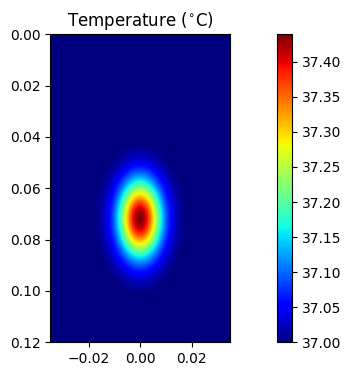

In [8]:
# Editing
IsppaRatio=5.0/BaseIsppa
Tmap=(ResTemp[:,cy,:].T-BaselineTemperature)*IsppaRatio+BaselineTemperature
crlims=[0,1,2,3]

# Create figure and axis
thermal_figure = plt.figure(figsize=(12, 4))
thermal_plot_1 = thermal_figure.figure.subplots(1,1)

# Display temperature map
im1 = thermal_plot_1.imshow(
    Tmap,
    extent=[xfield.min(), xfield.max(), zfield.max(), zfield.min()],
    cmap=plt.cm.jet,
    vmin=BaselineTemperature
)

# Create mesh grid for contour plot
YY, ZZ = np.meshgrid(yfield, zfield)

# Plot contours
thermal_plot_1.contour(
    YY, ZZ, MaterialMap[cx,:,:].T,
    levels=crlims,
    cmap=plt.cm.gray
)

# Set titles
thermal_plot_1.set_title('Temperature ($^{\circ}$C)')

# Add color bars
plt.colorbar(im1, ax=thermal_plot_1)

# Show plots
plt.show()


## Run BHTE with OpenCL

In [9]:
# Calculate BHTE using OpenCL
InitOpenCL(gpu_device)
ResTemp_2,ResDose_2,MonitorSlice_2,Qarr_2 = BHTE(pressure,
                                                 MaterialMap,
                                                 MaterialList,
                                                 (xfield[1]-xfield[0]),
                                                 TotalDurationSteps,
                                                 nStepsOn,
                                                 cy,
                                                 nFactorMonitoring=nFactorMonitoring,
                                                 dt=dt,
                                                 DutyCycle=DutyCycle,
                                                 Backend='OpenCL',
                                                 stableTemp=BaselineTemperature)

Apple M1 Max

/Users/acoreas/opt/anaconda3/envs/bbmac_visco/lib/python3.9/site-packages/pytools/persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "



Selecting device:  Apple M1 Max
0 12000
1200 12000
2400 12000
3600 12000
4800 12000
6000 12000
7200 12000
8400 12000
9600 12000
10800 12000
Done BHTE


# Plot OpenCL results

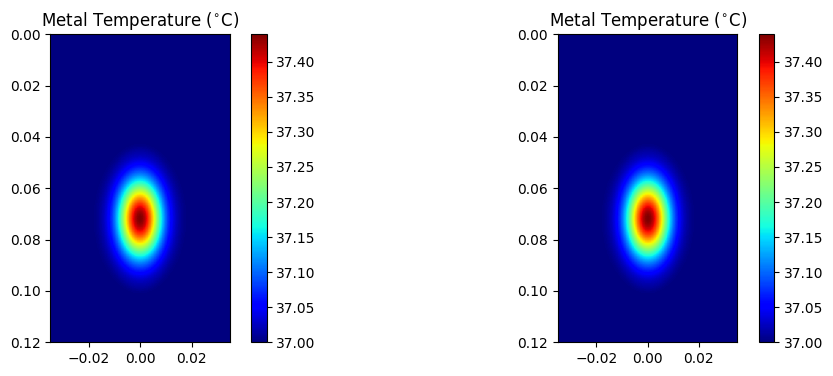

In [10]:
# Editing
IsppaRatio=5.0/BaseIsppa
Tmap_2=(ResTemp_2[:,cy,:].T-BaselineTemperature)*IsppaRatio+BaselineTemperature
Tmap=(ResTemp[:,cy,:].T-BaselineTemperature)*IsppaRatio+BaselineTemperature
crlims=[0,1,2,3]

# Create figure and axis
thermal_figure = plt.figure(figsize=(12, 4))
thermal_plot_1,thermal_plot_2 = thermal_figure.figure.subplots(1,2)

# Display Metal temperature map
im1 = thermal_plot_1.imshow(
    Tmap_2,
    extent=[xfield.min(), xfield.max(), zfield.max(), zfield.min()],
    cmap=plt.cm.jet,
    vmin=BaselineTemperature
)

# Display current gpu temperature map
im2 = thermal_plot_2.imshow(
    Tmap,
    extent=[xfield.min(), xfield.max(), zfield.max(), zfield.min()],
    cmap=plt.cm.jet,
    vmin=BaselineTemperature
)


# Set titles
thermal_plot_1.set_title('Metal Temperature ($^{\circ}$C)')
thermal_plot_2.set_title(gpu_backend + ' Temperature ($^{\circ}$C)')

# Add color bars
plt.colorbar(im1, ax=thermal_plot_1)
plt.colorbar(im2, ax=thermal_plot_2)

# Show plots
plt.show()

## Compare data

Data matches? False
Dice Coefficient: 0.9233107994966965
Difference Histogram
0.00 to 0.00: 2332959
0.00 to 0.00: 21361
0.00 to 0.00: 38369
0.00 to 0.00: 16127
0.00 to 0.00: 29340
0.00 to 0.00: 16616
0.00 to 0.00: 36473
0.00 to 0.00: 10907
0.00 to 0.00: 5958
0.00 to 0.00: 118
Mean square error: 5.110177930310803e-11
Normalized root mean square error: 1.6280633127753648e-05


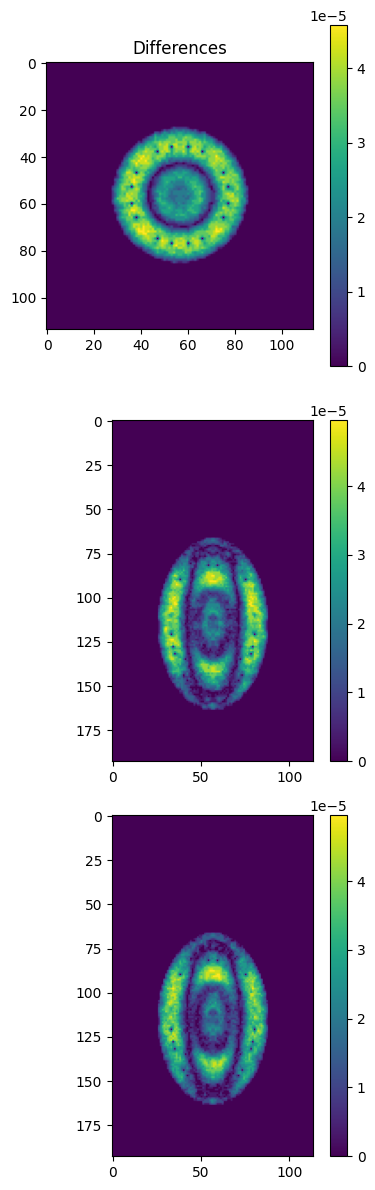

In [11]:
tolerance = 1e-6
data_match = np.all(ResTemp_2==ResTemp)
print(f"Data matches? {data_match}")

if not data_match:
    # DICE coefficient calculation
    matches = abs(ResTemp - ResTemp_2) < tolerance
    matches_count = len(matches[matches==True])
    dice_coeff = 2 * matches_count / (ResTemp_2.size + ResTemp.size)
    print(f"Dice Coefficient: {dice_coeff}")

    # Plot difference images
    diffs = abs(ResTemp.T - ResTemp_2.T)

    fig, axs = plt.subplots(3, 1, figsize=(4, 12))
    axs[0].set_title('Differences')
    diff_im1 = axs[0].imshow(diffs[diffs.shape[0]//2,:,:])
    diff_im2 = axs[1].imshow(diffs[:,:,diffs.shape[2]//2])
    diff_im3 = axs[2].imshow(diffs[:,diffs.shape[1]//2,:])
    plt.colorbar(diff_im1, ax=axs[0])
    plt.colorbar(diff_im2, ax=axs[1])
    plt.colorbar(diff_im3, ax=axs[2])
    

    plt.tight_layout()

    # Get difference histograms
    hist,bins = np.histogram(diffs)
    print(f"Difference Histogram")
    for bin in range(len(bins)-1):
        print(f"{bins[bin]:.2f} to {bins[bin+1]:.2f}: {hist[bin]}")

    # Mean square error calculation
    mse = mean_squared_error(ResTemp_2,ResTemp)
    print(f"Mean square error: {mse}")

    # Normalized root mean square error calculation
    nrmse = normalized_root_mse(ResTemp_2,ResTemp,normalization='min-max')
    print(f"Normalized root mean square error: {nrmse}")